In [41]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from network import solve_ode_network, compute_envelope_fc
from scipy.signal import hilbert, butter, buttord, filtfilt
from scipy.signal import hilbert, hilbert2, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import iirdesign, sosfilt

In [2]:
def plot_x_values(x_values):
    j = np.array([0,20])
    fig, axes = plt.subplots(len(j), 1, figsize=(12, len(j)*2))

    for i in range(len(j)):
        axes[i].plot(x_values[:,j[i]], label=f'j={j[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(f'x_{j[i]}')
        axes[i].set_title(f'Solution of ODE for x_{j[i]}')
        axes[i].legend()

    plt.tight_layout()


In [3]:
mat = loadmat('../references/AAL78/C78.mat')
C = mat['C']

In [89]:
# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def bandpass_filter_auto_order(data, lowcut, highcut, fs, gpass=3, gstop=40):
    # Normalized passband and stopband edges
    wp = [lowcut / (0.5 * fs), highcut / (0.5 * fs)]
    ws = [(lowcut - lowcut*0.1) / (0.5 * fs), (highcut + highcut*0.1) / (0.5 * fs)]
    
    # Design the filter using iirdesign
    sos = iirdesign(wp, ws, gpass, gstop, analog=False, ftype='butter', output='sos')
    
    # Apply the filter
    y = sosfilt(sos, data)
    return y


In [100]:
# def smooth_signal(signal, window_length, polyorder):
#     """Apply Savitzky-Golay filter to smooth the signal."""
#     # Ensure window length is odd and less than the signal length
#     if window_length % 2 == 0:
#         window_length += 1
#     if window_length > len(signal):
#         window_length = len(signal) - 1 if len(signal) % 2 else len(signal) - 2
#     return savgol_filter(signal, window_length, polyorder)

# def smoothening_envelope(amplitude_env, window_length=51, polyorder=3):
#     smooth_outline = np.zeros_like(amplitude_env)
    
#     for i in range(amplitude_env.shape[1]):
#         # First, smooth the signal
#         smoothed_signal = smooth_signal(amplitude_env[:, i], window_length, polyorder)
        
#         # Find peaks in the smoothed signal
#         peaks, _ = find_peaks(smoothed_signal)
        
#         if len(peaks) == 0:
#             smooth_outline[:, i] = amplitude_env[:, i]
#             continue
        
#         x_values = np.arange(amplitude_env.shape[0])
        
#         # Use quadratic interpolation for a smoother outline
#         peak_interpolation = interp1d(peaks, smoothed_signal[peaks], kind='cubic', bounds_error=False, fill_value='extrapolate')
        
#         # Generate the smooth outline
#         smooth_outline[:, i] = peak_interpolation(x_values)
    
#     return smooth_outline

def smoothening_envelope(amplitude_env, smoothing_window_length=51, polyorder=3, prominence=None, width=None, distance=None):
    smooth_outline = np.zeros_like(amplitude_env)
    
    # Apply a Savitzky-Golay filter to the amplitude envelope for pre-smoothing
    for i in range(amplitude_env.shape[1]):
        smoothed_env = savgol_filter(amplitude_env[:, i], smoothing_window_length, polyorder)

        # Find peaks in the smoothed amplitude envelope
        peaks, _ = find_peaks(smoothed_env, prominence=prominence, width=width, distance=distance)

        # If no peaks are found, return the original signal or handle as required
        if len(peaks) == 0:
            smooth_outline[:, i] = amplitude_env[:, i]
            continue

        # Create the x-values for interpolation
        x_values = np.arange(amplitude_env.shape[0])

        # Interpolate between peaks to create a smoother outline
        # If cubic interpolation fails due to insufficient points, fall back to linear
        try:
            peak_interpolation = interp1d(peaks, smoothed_env[peaks], kind='cubic', bounds_error=False, fill_value='extrapolate')
        except ValueError:
            peak_interpolation = interp1d(peaks, smoothed_env[peaks], kind='linear', bounds_error=False, fill_value='extrapolate')
        
        # Generate the smooth outline for the current node
        smooth_outline[:, i] = peak_interpolation(x_values)

    return smooth_outline

In [84]:
def smoothening_envelope(amplitude_env):
    # Initialize the smooth outline matrix with the same shape as amplitude_env
    smooth_outline = np.zeros_like(amplitude_env)
    
    # Iterate over each node and compute the smooth outline
    for i in range(amplitude_env.shape[1]):
        # Find peaks for the current node's amplitude envelope
        peaks, _ = find_peaks(amplitude_env[:, i])
        
        # Handle the case when no peaks are found
        if len(peaks) == 0:
            # If no peaks are found, we could choose to return the original signal,
            # or handle this case according to the specific requirements of the analysis
            smooth_outline[:, i] = amplitude_env[:, i]
            continue
        x_values = np.arange(amplitude_env.shape[0])
        # Interpolate between peaks to create a smoother outline
        peak_interpolation = interp1d(peaks, amplitude_env[peaks, i], kind='cubic', bounds_error=False, fill_value='extrapolate')
        
        # Use the interpolation function to generate the smooth outline for the current node
        smooth_outline[:, i] = peak_interpolation(x_values)
    return smooth_outline


In [63]:
def signal_processing_on_hopf(signal, C, dt, f=12, G=0.5):   
    # Filter parameters
    fs = 1/dt
    band_lowcut = f - 2
    band_highcut = f + 2
    lowpass_cutoff = 0.2

    # Preallocate arrays for filtered signals
    filtered_signal = np.zeros_like(signal)

    # Band-pass filter for each region
    for i in range(78):
        filtered_signal[:, i] = bandpass_filter(signal[:, i], band_lowcut, band_highcut, fs)
        # filtered_signal[:, i] = bandpass_filter_auto_order(signal[:, i], band_lowcut, band_highcut, fs)
        
    # Calculate the Hilbert transform to get the amplitude envelope
    amplitude_env = np.abs(hilbert(filtered_signal))

    # Smoothening the envelope
    smoothened_env = smoothening_envelope(amplitude_env)

    # Low-pass filter the amplitude envelope
    analytical_signal = hilbert(smoothened_env)
    ultra_slow = np.zeros_like(amplitude_env)

    for i in range(78):
        # ultra_slow[:, i] = lowpass_filter(amplitude_env[:, i], lowpass_cutoff, fs)
        ultra_slow[:, i] = lowpass_filter(smoothened_env[:, i], lowpass_cutoff, fs)

    return signal, filtered_signal, analytical_signal, amplitude_env, smoothened_env, ultra_slow

In [66]:
def plot_signal_processing_stages(x_values, filtered_x, amplitude_env_x, smoothened_env, ultra_slow_x):
    
    # Plot setup
    fig, axs = plt.subplots(4, 1, figsize=(12, 8))
    
    # Original signal
    axs[0].plot(x_values, label='Original Signal')
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    
    # Amplitude envelope
    axs[1].plot(amplitude_env_x, label='Amplitude Envelope', color='green')
    axs[1].set_title('Amplitude Envelope (Hilbert Transform)')
    axs[1].set_ylabel('Amplitude')
    # axs[1].legend()

    # Filtered signal
    axs[2].plot(filtered_x, label='Filtered Signal', color='orange')
    axs[2].plot(smoothened_env, label='Amplitude Envelope', color='green')
    axs[2].set_title('Band-Pass Filtered Signal')
    axs[2].set_ylabel('Amplitude')
    
    # Ultra-slow fluctuations
    axs[3].plot(ultra_slow_x, label='Ultra Slow Fluctuations', color='red')
    axs[3].set_title('Ultra-Slow Fluctuations of the Amplitude Envelope')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Amplitude')

    # Adjusting layout and showing the plot
    plt.tight_layout()
    plt.show()

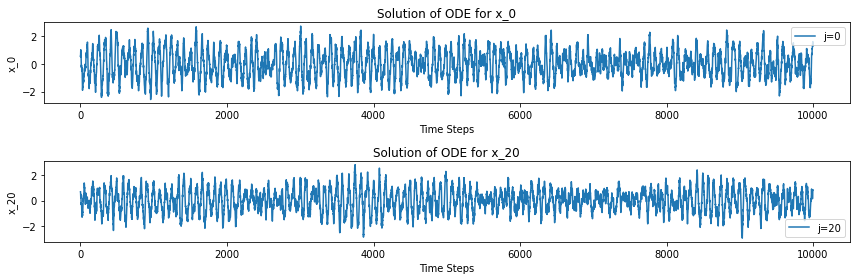

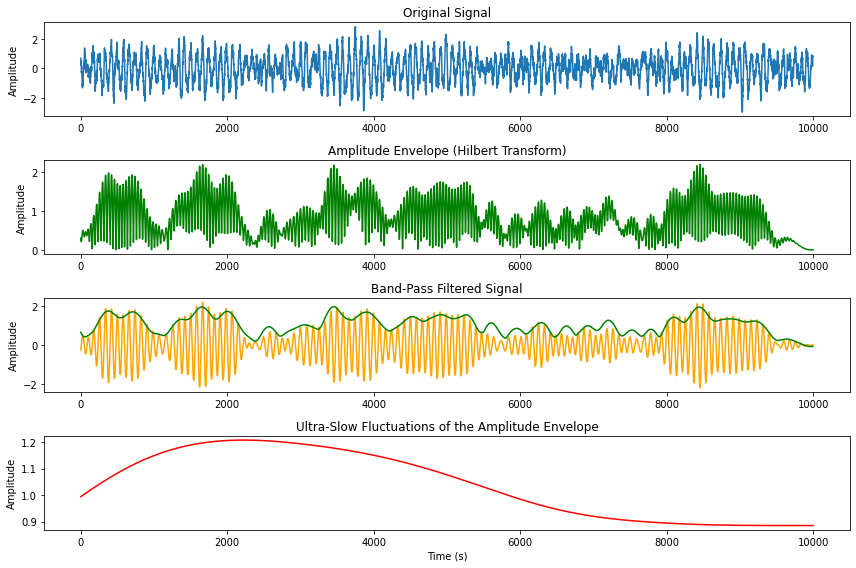

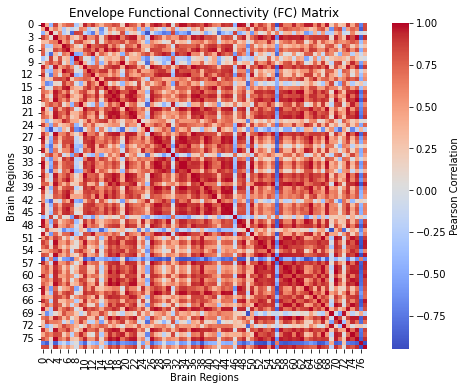

In [114]:
f=12
G=0.5
num_steps = 10000  # total steps
dt = 0.001  # time step
a = 0.0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * f  # angular frequencies for each neuron
beta = 5 # noise level

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
r_values = np.sqrt(x_values**2 + y_values**2)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

index = 20
x = x_signal[:,index]
band_pass_fil = filtered_x[:, index]
amplitude_env = amplitude_env_x[:, index]
ultra_slow = ultra_slow_x[:,index]
smoothened_env = smoothened_env_x[:, index]

plot_x_values(x_signal)
plot_signal_processing_stages(x, band_pass_fil, amplitude_env, smoothened_env, ultra_slow)

# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(envelope_fc, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

## Metastability

In [115]:
# Function to calculate Kuramoto order parameter R(t) and metastability
def calculate_kuramoto_and_metastability(analytical_x):
    # Calculate the instantaneous phase φk(t) for each brain region
    instantaneous_phase = np.angle(analytical_x)

    # Calculate the Kuramoto order parameter R(t) over time
    R_t = np.abs(np.sum(np.exp(1j * instantaneous_phase), axis=1))/10000

    # Calculate metastability as the standard deviation of the Kuramoto order parameter
    metastability = np.std(R_t)
    
    return R_t, metastability

### Fig 6c.

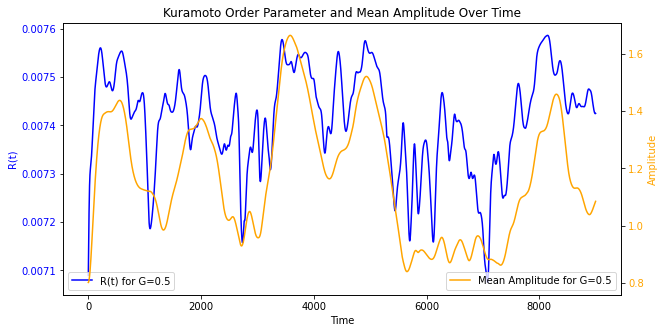

In [116]:
_, _, analytical_x, amplitude_env_x, smoothened_env_x, _ = signal_processing_on_hopf(signal, C, dt, f, G)
R_t, _ = calculate_kuramoto_and_metastability(analytical_x)
mean_amplitude_x = np.mean(smoothened_env_x, axis=1)

# Create a figure and a first axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot R_t (Kuramoto Order Parameter) on the first axis (ax1) in blue
ax1.plot(R_t[:9000], label=f'R(t) for G={G}', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('R(t)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='lower left')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot mean_amplitude_x on the second axis (ax2) in orange
ax2.plot(mean_amplitude_x[:9000], label=f'Mean Amplitude for G={G}', color='orange')
ax2.set_ylabel('Amplitude', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='lower right')

# Title of the combined plot
plt.title('Kuramoto Order Parameter and Mean Amplitude Over Time')

# Show the plot with two y-axes
plt.show()

## CCD

(10000, 78)
(10000, 3003)


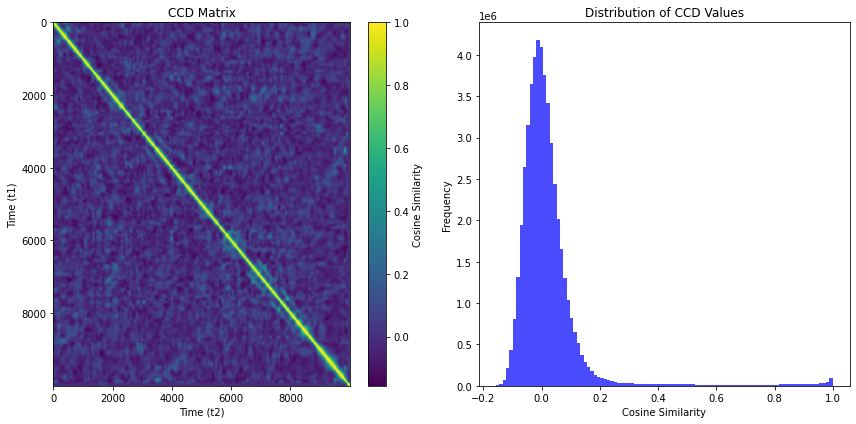

In [126]:
instantaneous_phase = np.angle(analytical_x)
print(instantaneous_phase.shape)
# Number of time points and brain regions
num_time_points, num_brain_regions = instantaneous_phase.shape

# Step 1: Calculate V(t) for each time step
V_t = []
for t in range(num_time_points):
    phase_diff = np.abs(instantaneous_phase[t, :, None] - instantaneous_phase[t, None, :])
    cos_phase_diff = np.cos(phase_diff)
    # We exclude the diagonal to not include the coherence of a node with itself
    np.fill_diagonal(cos_phase_diff, 0)
    V_t.append(cos_phase_diff[np.triu_indices(num_brain_regions, k=1)])
V_t = np.array(V_t)
print(V_t.shape)
# Step 2: Calculate the CCD matrix
CCD = np.corrcoef(V_t)
CCD_values = CCD[np.triu_indices_from(CCD, k=1)]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Step 3: Plot the CCD matrix on the first subplot
im = axes[0].imshow(CCD, cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im, ax=axes[0], label='Cosine Similarity')
axes[0].set_title('CCD Matrix')
axes[0].set_xlabel('Time (t2)')
axes[0].set_ylabel('Time (t1)')
axes[0].invert_yaxis()  # Invert the y-axis

# Step 4: Plot the CCD distribution on the second subplot
axes[1].hist(CCD_values, bins=100, color='blue', alpha=0.7)
axes[1].set_title('Distribution of CCD Values')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

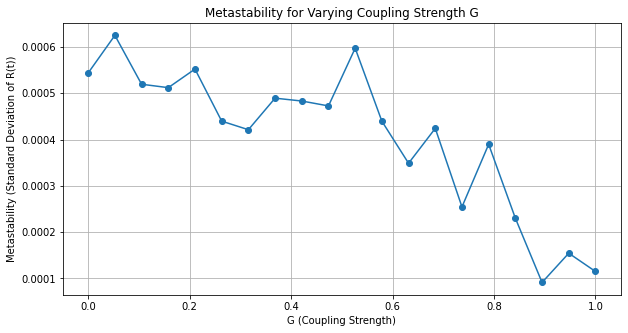

In [104]:
# Vary the coupling strength G from 0 to 1 with 30 points
G_values = np.linspace(0, 1, 20)
metastabilities = []

# Calculate metastability for varying G and plot the metastability
for G in G_values:
    x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
    _, _, analytical_x, _, _, _ = signal_processing_on_hopf(x_values, C, dt, f, G)
    _, metastability = calculate_kuramoto_and_metastability(analytical_x)
    metastabilities.append(metastability)

# Plot metastability over G values
plt.figure(figsize=(10, 5))
plt.plot(G_values, metastabilities, marker='o')
plt.title('Metastability for Varying Coupling Strength G')
plt.xlabel('G (Coupling Strength)')
plt.ylabel('Metastability (Standard Deviation of R(t))')
plt.grid(True)
plt.show()

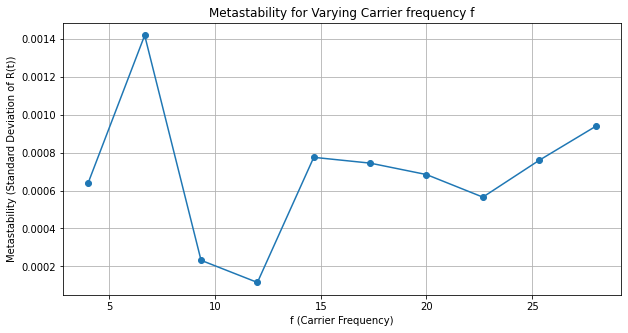

In [105]:
# Vary the coupling strength G from 0 to 1 with 30 points
f_values = np.linspace(4, 28, 10)
metastabilities = []

# Calculate metastability for varying G and plot the metastability
for f in f_values:
    x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
    _, _, analytical_x, _, _, _ = signal_processing_on_hopf(x_values, C, dt, f, G)
    _, metastability = calculate_kuramoto_and_metastability(analytical_x)
    metastabilities.append(metastability)

# Plot metastability over G values
plt.figure(figsize=(10, 5))
plt.plot(f_values, metastabilities, marker='o')
plt.title('Metastability for Varying Carrier frequency f')
plt.xlabel('f (Carrier Frequency)')
plt.ylabel('Metastability (Standard Deviation of R(t))')
plt.grid(True)
plt.show()